In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

In [2]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")

In [4]:
# get all ground truth dataframe
gt_df = pd.DataFrame()
for (collection_name, phone_name), df in tqdm(train_df.groupby(["collectionName", "phoneName"])):
    path = data_dir / f"train/{collection_name}/{phone_name}/ground_truth.csv"
    df = pd.read_csv(path)  
    gt_df = pd.concat([gt_df, df]).reset_index(drop=True)   
gt_df.head()

  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423576,-122.094132,33.21,551.44,1.1,0.0,0.0,12.7
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423576,-122.094132,33.21,552.44,1.1,0.0,0.0,12.7
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423576,-122.094132,33.21,553.44,1.1,0.0,0.0,12.7
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423576,-122.094132,33.20,554.44,1.1,0.0,0.0,12.7
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423576,-122.094132,33.20,555.44,1.1,0.0,0.0,12.7


# Target Place

In [9]:
target_collection = '2021-04-29-US-SJC-2'
target_gt_df = gt_df[gt_df["collectionName"]==target_collection].reset_index(drop=True)
target_collection

'2021-04-29-US-SJC-2'

In [19]:
from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd
import folium

In [11]:
# change pd.DataFrame -> gpd.GeoDataFrame
target_gt_df["geometry"] = [Point(p) for p in target_gt_df[["lngDeg", "latDeg"]].to_numpy()]
target_gt_gdf = gpd.GeoDataFrame(target_gt_df, geometry=target_gt_df["geometry"])
target_gt_gdf.head(5)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,geometry
0,2021-04-29-US-SJC-2,Pixel4,1303757946435,37.334479,-121.899598,56.64,263.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
1,2021-04-29-US-SJC-2,Pixel4,1303757947435,37.334479,-121.899598,56.64,264.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
2,2021-04-29-US-SJC-2,Pixel4,1303757948435,37.334479,-121.899598,56.64,265.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
3,2021-04-29-US-SJC-2,Pixel4,1303757949435,37.334479,-121.899598,56.64,266.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)
4,2021-04-29-US-SJC-2,Pixel4,1303757950435,37.334479,-121.899598,56.64,267.44,0.5,0.0,0.0,61.1,POINT (-121.89960 37.33448)


<AxesSubplot:>

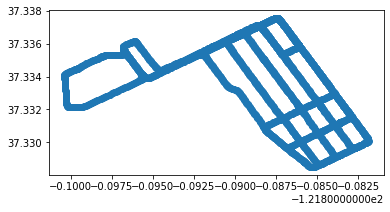

In [12]:
target_gt_gdf.plot()

In [20]:
# get road data from open street map by osmnx
offset = 0.1**5
bbox = target_gt_gdf.bounds + [-offset, -offset, offset, offset]
east = bbox["minx"].min()
west = bbox["maxx"].max()
south = bbox["miny"].min()
north = bbox["maxy"].max()
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

In [23]:
# ox.folium.plot_graph_folium(G)

In [24]:
nodes, edges = momepy.nx_to_gdf(G)

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/momepy/utils.py:418: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


In [25]:
nodes.head()

,y,x,highway,street_count,nodeID,ref,geometry
0,37.335294,-121.897948,stop,3,0,NaN,POINT (-121.89795 37.33529)
1,37.335370,-121.896596,stop,3,1,NaN,POINT (-121.89660 37.33537)
2,37.336402,-121.898691,traffic_signals,4,2,NaN,POINT (-121.89869 37.33640)
3,37.336552,-121.898785,traffic_signals,4,3,NaN,POINT (-121.89878 37.33655)
4,37.337067,-121.897707,NaN,3,4,NaN,POINT (-121.89771 37.33707)


In [26]:
edges.head()

,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end
0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89795 37.33529, -121.89791 37...",NaN,NaN,NaN,NaN,NaN,0,1
1,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89660 37.33537, -121.89673 37...",NaN,NaN,NaN,NaN,NaN,1,0
2,417910134,North Almaden Boulevard,secondary,True,62.399,"LINESTRING (-121.89660 37.33537, -121.89648 37...",NaN,NaN,NaN,NaN,NaN,1,111
3,417891836,West Julian Street,secondary,True,18.264,None,3,NaN,NaN,NaN,NaN,2,91
4,158245357,North Almaden Boulevard,secondary,True,139.706,"LINESTRING (-121.89869 37.33640, -121.89864 37...",1,NaN,NaN,NaN,NaN,2,0


<AxesSubplot:>

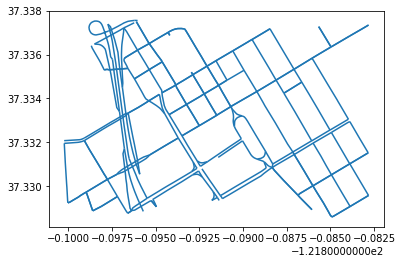

In [27]:
edges.plot()

# only the relevent roads

In [29]:
edges = edges.dropna(subset=["geometry"]).reset_index(drop=True)
hits = bbox.apply(lambda row: list(edges.sindex.intersection(row)), axis=1)
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(edges.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(target_gt_gdf.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=target_gt_gdf.crs)

In [30]:
tmp.head()

,pt_idx,line_i,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end,point
0,45,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89847 37.33505)
1,46,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89837 37.33509)
2,47,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89827 37.33514)
3,48,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89819 37.33517)
4,49,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",NaN,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,NaN,NaN,NaN,91,49,POINT (-121.89813 37.33520)


# Find closest road

In [31]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

# Discard any lines that are greater than tolerance from points
tolerance = 0.0005  
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")
closest = closest.drop_duplicates("line_i").reset_index(drop=True)

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  """Entry point for launching an IPython kernel.


<AxesSubplot:>

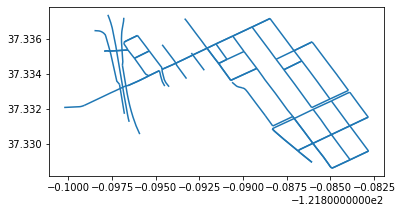

In [32]:
closest.plot()

In [33]:
closest.head()

,line_i,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end,point,snap_dist
0,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",None,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[1, 2]",yes,None,None,None,91,49,POINT (-121.89810 37.33522),0.000482
1,1.0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89660 37.33537, -121.89673 37...","[1, 2]",yes,None,None,None,1,0,POINT (-121.89791 37.33529),0.000014
2,0.0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89795 37.33529, -121.89791 37...","[1, 2]",yes,None,None,None,0,1,POINT (-121.89783 37.33530),0.000014
3,58.0,"[28357317, 28357351, 28357352, 157782059, 2835...",Guadalupe Freeway,motorway,True,690.498,"LINESTRING (-121.89652 37.33125, -121.89657 37...",3,yes,65 mph,CA 87,None,28,51,POINT (-121.89723 37.33531),0.000013
4,2.0,417910134,North Almaden Boulevard,secondary,True,62.399,"LINESTRING (-121.89660 37.33537, -121.89648 37...",None,None,None,None,None,1,111,POINT (-121.89656 37.33528),0.000031


In [36]:
closest.shape

(107, 16)

# Generate road points

In [34]:
line_points_list = []
split = 50  # param: number of split in each LineString
for dist in range(0, split, 1):
    dist = dist/split
    line_points = closest["geometry"].interpolate(dist, normalized=True)
    line_points_list.append(line_points)
line_points = pd.concat(line_points_list).reset_index(drop=True)
line_points = line_points.reset_index().rename(columns={0:"geometry"})
line_points["lngDeg"] = line_points["geometry"].x
line_points["latDeg"] = line_points["geometry"].y